## Predicting Household Self-Reported Income in Hubballi-Dharwad, Karnataka, India： Machine Learning Approaches based on Customer Survey

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

In [2]:
# Import customer dataset with water consumption
df = pd.read_csv('../data/CS/Hubballi_Dhaward_Water_Consumption_Nightlight_Population.csv')

# Rename 'monthly_family_income' to 'Target'
df = df.rename(columns={'monthly_family_income': 'Target'})

# Drop rows with missing values in the 'Target' column
df = df.dropna(subset=['Target']).reset_index(drop=True)
df.shape

(34811, 37)

In [3]:
df['Target'].value_counts()

Target
10-20K    18982
0-10K      8758
20-50K     6357
> 50K       714
Name: count, dtype: int64

In [4]:
# Convert target labels to numeric values
label_mapping = {'0-10K': 0, '10-20K': 1, '20-50K': 2, '> 50K': 3}
df['Target'] = df['Target'].map(label_mapping)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, shuffle=True)
train_df.shape, test_df.shape

((27848, 37), (6963, 37))

In [5]:
X_train = train_df.drop(columns='Target')
y_train = train_df['Target']

X_test = test_df.drop(columns='Target')
y_test = test_df['Target']


#### Data Preproecessing

- Handling missing values and data cleaning.

- Data normalization and standardization.

- Feature selection and engineering, including spatial features.


In [6]:
X_train.columns

Index(['objectid', 'rrno', 'pzone', 'freq', 'permonthunitskl', 'sl_no', 'area',
       'dma', 'priority_group', 'property_type', 'latitude', 'longitude',
       'property_detail', 'type_of_roof', 'property_sub_type', 'num_of_flats',
       'cs_floor', 'number_of_residents', 'builtup_area', 'owner_caste',
       'connection_size', 'supply_frequency', 'supply_in_hours', 'pressure',
       'water_quality', 'other_connection_needed', 'willingness_to_pay',
       'water_storage_type', 'sewage_connection_type', 'rainwater_harvesting',
       'ration_card', 'near_dist', 'cluster', 'nightlight', 'population',
       'num_floors'],
      dtype='object')

In [7]:
numeric_features = ['num_of_flats', 'number_of_residents']

binary_features = ['builtup_area', 'pressure', 'water_quality', 'rainwater_harvesting', 'ration_card']

categorical_features = ['property_type', 'property_sub_type', 'property_detail', 'type_of_roof', 'cs_floor', 'connection_size', 'supply_frequency', 'supply_in_hours', 'water_storage_type', 
                        'sewage_connection_type', 'owner_caste', 'dma']

drop_features = ['rrno', 'pzone', 'permonthunitskl', 'sl_no', 'latitude', 'longitude', 'priority_group', 'freq', 'other_connection_needed', 'willingness_to_pay',
                 'objectid', 'near_dist', 'nightlight', 'population', 'num_floors', 'area']


In [8]:
print(len(numeric_features) + len(binary_features) + len(categorical_features) + len(drop_features))
categorical_features += binary_features

35


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop="if_binary"))
        ]), categorical_features),
        
        ("drop", 'drop', drop_features)
    ]
)

In [10]:
# Fit the preprocessor and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

onehot_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

feature_names = (
    numeric_features
    + preprocessor.named_transformers_['cat']['encoder']
    .get_feature_names_out(categorical_features)
    .tolist()
)

### 4. Methodology

- Metric scores

classification report: accuracy, AUC-ROC score for each group

- Machine Learning Models

Description of selected models (e.g., Logistic, Random Forest, XGBoost, lightGBM).
Justification for model selection.

In [11]:
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import check_classification_targets

class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    #https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
    """
    A classifier that can be trained on a range of classes.
    @param classifier: A scikit-learn classifier.
    """
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
        self.classes_ = None  # Add this to store the classes

    def fit(self, X, y, **kwargs):
        # Store the classes
        self.classes_ = np.sort(np.unique(y))
        self.uniques_class = self.classes_

        if self.uniques_class.shape[0] > 2:
            for i in range(self.uniques_class.shape[0] - 1):
                binary_y = (y > self.uniques_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y, **kwargs)
                self.clfs[i] = clf

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        h = [self.clfs[k].predict_proba(X)[:, 1].reshape(-1, 1) for k in self.clfs]

        p_x_first = 1 - h[0]
        p_x_last = h[-1]
        p_x_middle = [h[i] - h[i + 1] for i in range(len(h) - 1)]

        probs = np.hstack([p_x_first, *p_x_middle, p_x_last])
        return probs


In [12]:
def cross_val_evaluate_model(model, features, labels, cv, class_labels):

    # Create a StratifiedKFold object
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)

    # Cross-validation predictions with stratification
    preds = cross_val_predict(model, features, labels, cv=stratified_kfold, method='predict')
    probs = cross_val_predict(model, features, labels, cv=stratified_kfold, method='predict_proba')

    # Classification report
    print(classification_report(labels, preds, target_names=class_labels))

    # Calculate ROC-AUC score
    y_true = pd.get_dummies(labels).values
    y_pred = pd.DataFrame(probs, columns=class_labels).values
    roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc}")

    # ROC Curve for each class
    fpr = {}
    tpr = {}
    roc_auc_dict = {}

    for i, label in enumerate(class_labels):
        fpr[label], tpr[label], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[label] = auc(fpr[label], tpr[label])

    plt.figure()
    for label in class_labels:
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc_dict[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()

# Labels for classification
labels = ['0-10K', '10-20K', '20-50KL', '>50K']


Original training set size: (27848, 68), (27848,)
Balanced training set size: (60692, 68), (60692,)
Ordinal Logistic Regression Model with Over-Sampling
              precision    recall  f1-score   support

       0-10K       0.66      0.64      0.65     15173
      10-20K       0.47      0.41      0.44     15173
     20-50KL       0.50      0.48      0.49     15173
        >50K       0.72      0.86      0.78     15173

    accuracy                           0.60     60692
   macro avg       0.59      0.60      0.59     60692
weighted avg       0.59      0.60      0.59     60692

ROC-AUC Score: 0.8375459939004671


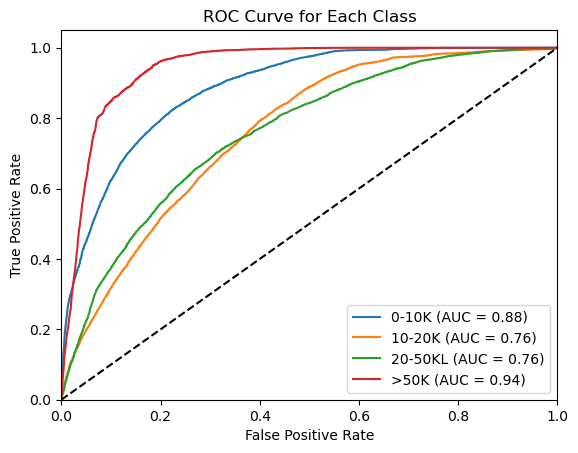

Ordinal Random Forest Model with Over-Sampling
              precision    recall  f1-score   support

       0-10K       0.81      0.78      0.79     15173
      10-20K       0.68      0.69      0.69     15173
     20-50KL       0.74      0.68      0.71     15173
        >50K       0.87      0.97      0.91     15173

    accuracy                           0.78     60692
   macro avg       0.77      0.78      0.77     60692
weighted avg       0.77      0.78      0.77     60692

ROC-AUC Score: 0.9310235339139559


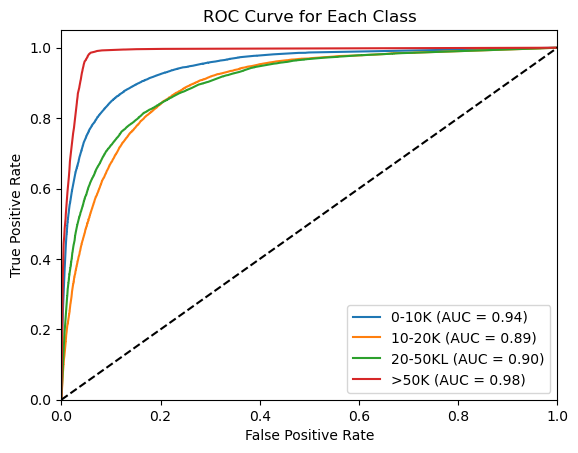

Ordinal Gradient Boosting Model with Over-Sampling
              precision    recall  f1-score   support

       0-10K       0.70      0.68      0.69     15173
      10-20K       0.60      0.56      0.58     15173
     20-50KL       0.59      0.55      0.57     15173
        >50K       0.79      0.93      0.86     15173

    accuracy                           0.68     60692
   macro avg       0.67      0.68      0.67     60692
weighted avg       0.67      0.68      0.67     60692

ROC-AUC Score: 0.8861421363236253


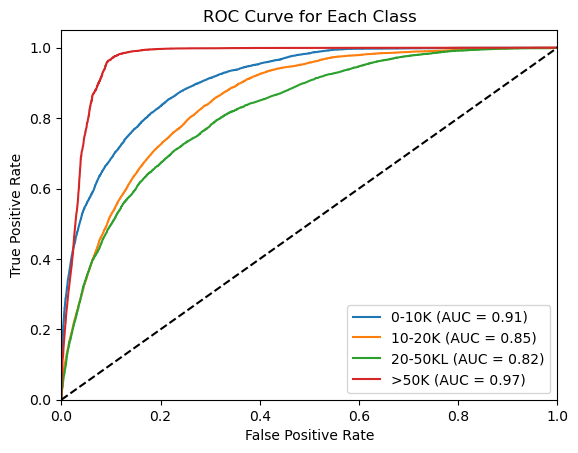

Ordinal LightGBM Model with Over-Sampling
              precision    recall  f1-score   support

       0-10K       0.77      0.71      0.74     15173
      10-20K       0.65      0.67      0.66     15173
     20-50KL       0.70      0.63      0.66     15173
        >50K       0.84      0.98      0.91     15173

    accuracy                           0.75     60692
   macro avg       0.74      0.75      0.74     60692
weighted avg       0.74      0.75      0.74     60692

ROC-AUC Score: 0.9224150096999928


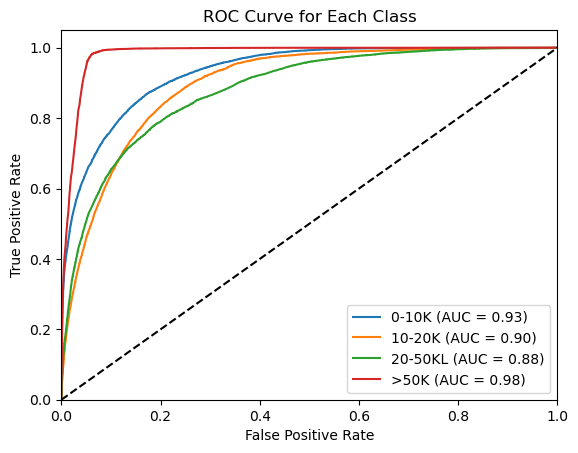

In [13]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=123)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print(f"Original training set size: {X_train_processed.shape}, {y_train.shape}")
print(f"Balanced training set size: {X_train_balanced.shape}, {y_train_balanced.shape}")

# Train and evaluate the ordinal logistic regression model
print("Ordinal Logistic Regression Model with Over-Sampling")
ordinal_logistic_model = OrdinalClassifier(clf=LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs'))
cross_val_evaluate_model(ordinal_logistic_model, X_train_balanced, y_train_balanced, cv=5, class_labels=labels)

# Train and evaluate the ordinal random forest model
print("Ordinal Random Forest Model with Over-Sampling")
ordinal_rf_model = OrdinalClassifier(clf=RandomForestClassifier(n_estimators=100, random_state=123))
cross_val_evaluate_model(ordinal_rf_model, X_train_balanced, y_train_balanced, cv=5, class_labels=labels)

# Train and evaluate the ordinal gradient boost model
print("Ordinal Gradient Boosting Model with Over-Sampling")
ordinal_gb_model = OrdinalClassifier(clf=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=123))
cross_val_evaluate_model(ordinal_gb_model, X_train_balanced, y_train_balanced, cv=5, class_labels=labels)

# Train and evaluate the ordinal LightGBM model
print("Ordinal LightGBM Model with Over-Sampling")
ordinal_lgb_model = OrdinalClassifier(clf=LGBMClassifier(objective='binary', random_state=123, learning_rate=0.1, verbosity=-1, n_jobs=-1))
cross_val_evaluate_model(ordinal_lgb_model, X_train_balanced, y_train_balanced, cv=5, class_labels=labels)